# Clustering Brands

### Imports

In [1]:
from datetime import datetime
import random
from itertools import combinations
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import metrics
from spectral import MySpectralClustering
%matplotlib inline

### Global Variables

In [2]:
global BRANDS_LIST              #List of Brand Names
global BRAND_FOLLOWERS          #Dictionary[Brand] =  [Brand Followers]
global C_DIST_MAT               #Condensed Distance Matrix 
global DIST_MAT                 #Distance Matrix
global Z
global CLUSTERS                 #Dictionary of Clusters
global N_BRANDS                 #Number of Brands
global N_CLUSTERS               #Number of Clusters

### Parameters

In [3]:
MAX_ROWS = 1404    #Maximum number of lines in file
N_BRANDS = 1404     #Number of Brands
N_CLUSTERS = 8     #Number of Clusters

### Quickfix for preparing data

In [4]:
def check_data_file():
    import os.path
    if os.path.exists('brand_followers.tsv'):     # Do not run this more than more
        out_file = open("brand_followers_fixed.tsv","w")
        with open('brand_followers.tsv','r') as data_file:
            data = data_file.read()
            data = data.replace('1114073faithhill','1114073\nfaithhill')
            out_file.write(data)
        out_file.close()
        os.remove('brand_followers.tsv')
        return True
    elif os.path.exists('brand_followers_fixed.tsv'):
        #out_file = open("brand_followers_fixed.tsv","w")
        #with open('brand_followers_final.tsv','r') as data_file:
            #data = data_file.read()
            #followers = data.split()
            #if len(followers) > 50:
                #out_file.write(data)
        #out_file.close()
        #os.remove('brand_followers_final.tsv')
        return True
    elif os.path.exists('brand_followers_final.tsv'):
        return True
    return False

In [5]:
if check_data_file():
    print('Data file is ready for use.')
else:
    print('Oops! Something went wrong here. Data file is not ready.')

Data file is ready for use.


### Load required data to memory

In [6]:
def load_data(number_of_brands_to_load=MAX_ROWS, verbose=False):
    global BRANDS_LIST
    global BRAND_FOLLOWERS
    global N_BRANDS
    global G
    
    
    start = datetime.now()    
    BRAND_FOLLOWERS = {}
    BRANDS_LIST = []
    #G = nx.Graph()
        
    # Selecting random brands to load
    if number_of_brands_to_load!= MAX_ROWS:
        choices = random.sample(range(1,MAX_ROWS), number_of_brands_to_load)
        max_row_id = max(choices)
    else:
        choices = range(1,MAX_ROWS+1)
        max_row_id = MAX_ROWS
        
    row_id = 0  #Line number
    skipped = 0 #to track number of lines skip
    
    with open('brand_followers_final.tsv') as data_file:
        for row in data_file:
            row_id += 1
            if row_id in choices: #Randomly selecting brands
                followers = row.split()
                brand = followers.pop(0)
                if len(followers) > 1000:  #Filtering brands with less than 50 followers
                    BRAND_FOLLOWERS[brand] = set([int(x) for x in followers])
                    BRANDS_LIST.append(brand)
                    #G.add_node(brand)
                    if verbose:
                        print(row_id,'Added',brand,'- Followers:',len(followers))
                else:
                    skipped +=1
                    if verbose:
                        print(row_id,'Skipped',brand,'- Followers:',len(followers))

                if row_id == MAX_ROWS or row_id==max_row_id:
                    stop = datetime.now()
                    N_BRANDS = number_of_brands_to_load - skipped
                    print('Loaded',N_BRANDS, 'rows in time',stop-start)
                    break
    return

In [7]:
load_data(N_BRANDS, verbose=True)

1 Added 100percentpure - Followers: 7196
2 Added 18rabbits - Followers: 1138
3 Added 20thcenturyfox - Followers: 500001
4 Added 34degrees - Followers: 1773
5 Added 3mnews - Followers: 25300
6 Added 5hourenergy - Followers: 14643
7 Added 7daysinutopia - Followers: 1401
8 Added 7up - Followers: 34448
9 Added 8oclockcoffee - Followers: 20778
10 Added 8thcontinentsoy - Followers: 2186
11 Added abreva - Followers: 1952
12 Added acer - Followers: 12345
13 Added acne_free_skin - Followers: 2090
14 Added acneorg - Followers: 4786
15 Added act - Followers: 5028
16 Added acti_pr - Followers: 3315
17 Added activia - Followers: 1970
18 Added acura_insider - Followers: 57961
19 Added acureorganics - Followers: 3304
20 Added adidas - Followers: 500001
21 Added afterglow - Followers: 1810
22 Added aidstillreqd - Followers: 8377
23 Added airheadscandy - Followers: 11468
24 Added airwickmexico - Followers: 8186
25 Added alaffiaskincare - Followers: 1133
26 Added alchimieforever - Followers: 1943
27 Add

### Computes the Distance Matrix

In [8]:
def compute_distance_matrix():
    global BRANDS_LIST
    global BRAND_FOLLOWERS
    global C_DIST_MAT
    global DIST_MAT
    global N_BRANDS
    #global G
    
    start = datetime.now()
    DIST_MAT = np.zeros((N_BRANDS,N_BRANDS))
    C_DIST_MAT = []
    
    edges = 0
    
    for tuple_pair in combinations(enumerate(BRANDS_LIST),2):
        #tuple_pair = (b1_idx, b1_name)(b2_idx, b2_name)
        b1 = BRAND_FOLLOWERS[tuple_pair[0][1]]
        b2 = BRAND_FOLLOWERS[tuple_pair[1][1]]
        
        #Jaccard Similarity Measure
        common_connections = len(b1.intersection(b2))
        total_connections = len(b1) + len(b2) - common_connections #More efficient than set(b1).union(b2)
        weight = common_connections/total_connections

        #Condensed Distance Matrix
        C_DIST_MAT.append(1.0 - weight)
        
        #Symmetrix Distance Matrix
        DIST_MAT[tuple_pair[0][0] , tuple_pair[1][0]] = DIST_MAT[tuple_pair[1][0] , tuple_pair[0][0]] = 1.0 - weight
        
        #Graph
        #if weight != 0.0:
            #G.add_edge(tuple_pair[0][1],tuple_pair[1][1], weight = weight)
        
        edges += 1
        if edges%80000 == 0:
            print(edges, 'edges loaded.')
        
    stop = datetime.now()
    
    print('Created',N_BRANDS * (N_BRANDS-1),'Condensed Distance Matrix')
    print('Created',N_BRANDS,'x',N_BRANDS,'Distance Matrix')
    #print('Created Graph of',G.number_of_nodes(),'nodes with',G.number_of_edges(),'edges')
    
    print('Elapsed Time',stop-start)
    
    #Freeing Memory - No point in heavy lifting after this point for the current implementation
    BRAND_FOLLOWERS = {}
    
    return

In [9]:
compute_distance_matrix()

80000 edges loaded.
160000 edges loaded.
240000 edges loaded.
320000 edges loaded.
400000 edges loaded.
480000 edges loaded.
560000 edges loaded.
640000 edges loaded.
720000 edges loaded.
800000 edges loaded.
880000 edges loaded.
960000 edges loaded.
Created 1958600 Condensed Distance Matrix
Created 1400 x 1400 Distance Matrix
Elapsed Time 0:37:49.771695


### Statistics of Computed Weights

In [10]:
print('Min:',np.amin(C_DIST_MAT))
print('Max:',np.amax(C_DIST_MAT))
print('Median:',np.median(C_DIST_MAT))
print('Mean:',np.mean(C_DIST_MAT))
print('Standard Deviation:',np.std(C_DIST_MAT))
print('Variance:',np.var(C_DIST_MAT))

Min: 0.516284487043
Max: 1.0
Median: 0.999557651356
Mean: 0.997213117782
Standard Deviation: 0.00875339539145
Variance: 7.6621930879e-05


Weight Distribution:
1.0 117657


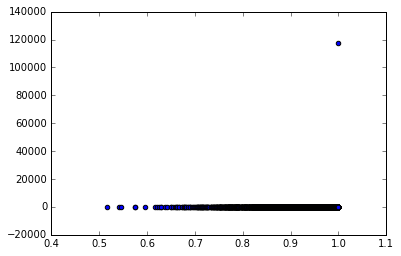

In [11]:
print('Weight Distribution:')
unique, counts = np.unique(C_DIST_MAT, return_counts=True)
plt.scatter(unique,counts)
print(unique[-1],counts[-1])

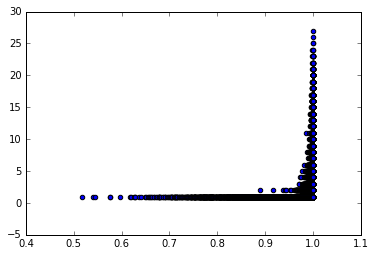

In [12]:
unique=unique[:-1]
counts=counts[:-1]
plt.scatter(unique,counts)

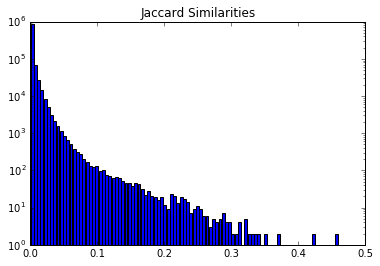

In [13]:
hist, bins = np.histogram(1-np.asarray(C_DIST_MAT),bins=100)
import math
#n_hist = []
#for h in hist:
#    n_hist.append(math.log(h))
    
width = 0.9 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.yscale("log")
plt.bar(center, hist, align='center', width=width)
plt.title('Jaccard Similarities')

### Clusters the given brands based on different Clustering Algorithms

In [14]:
def cluster_brands(method, num_clusters=N_CLUSTERS, linkage='complete', **kwargs):
    global C_DIST_MAT
    global BRANDS_LIST
    global Z
    global DIST_MAT
    global N_CLUSTERS
    global G
    
    #linkage = ['single', 'complete', 'average', 'weighted']
    
    start = datetime.now()
    
    if method =='Agglomerative':
        print('Clustering Algorithm: Agglomerative (complete)')
        clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage).fit(DIST_MAT)
        labels = clustering.labels_
        get_clusters(clustering.labels_, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
    elif method =='Hierarchical':
        print('Clustering Algorithm: Hierarchical (complete)')
        Z = sch.linkage(C_DIST_MAT, method=linkage)
        labels = sch.fcluster(Z,kwargs['threshold'])  #threshold = 0.99999999
        get_clusters(labels, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
        if kwargs['print_dendrogram']:
            #plt.clf()
            if N_BRANDS > 1000:
                fig = plt.figure(figsize=(100,100))
            else:
                fig = plt.figure()
            dd = sch.dendrogram(Z, labels=BRANDS_LIST,orientation='right')
            plt.savefig('figures/{}.png'.format(method))
        
    elif method == 'MySpectral' or method == 'MySpectral1':
        if method == 'MySpectral':
            print('Clustering Algorithm: MySpectral without do_scale')
        else:
            print('Clustering Algorithm: MySpectral with do_scale')
        clustering_labels = MySpectralClustering(k=num_clusters,do_scale=kwargs['do_scale']).cluster(DIST_MAT)
        labels = clustering_labels
        get_clusters(labels, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
    elif method == 'Spectral':
        print('Clustering Algorithm: Spectral (arpack,kmeans)')
        clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed',
                                       eigen_solver='arpack', assign_labels='kmeans').fit(DIST_MAT)
        labels = clustering.labels_
        get_clusters(clustering.labels_, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
    elif method == 'Girvan-Newman':
        print('Clustering Algorithm: Girvan-Newman')
        def most_central_edge(G):
            centrality = nx.edge_betweenness_centrality(G, weight='weight')
            return max(centrality, key=centrality.get)
        
        comp = nx.algorithms.community.girvan_newman(G, most_valuable_edge=most_central_edge)
        print('Clusters')
        for c in next(comp):
            print(c)

    stop = datetime.now()
    print('Clustering Completed in time',stop-start)
    
    return labels

### To generate the Cluster Dictionary and to display it

In [15]:
def get_clusters(cluster_labels, output, cluster_distribution=False, plot_in_2d=False):
    global CLUSTERS
    global N_BRANDS
    global BRANDS_LIST
    
    CLUSTERS = {}
    start = min(cluster_labels)
    stop = max(cluster_labels)
    
    #Initialize
    for i in range(start,stop+1):
        CLUSTERS[i] = []    
    
    #Cluster Dictionary
    for i in range(N_BRANDS):
        CLUSTERS[cluster_labels[i]].append(BRANDS_LIST[i])
    
    #Printing desired output
    if output=='LABEL':
        print('Displaying Clusters by labels...')
        for i in range(start,stop+1):
            print (i,':',CLUSTERS[i])
            
    elif output=='SIZE':
        print('Displaying Clusters by size...')
        for key in sorted(CLUSTERS, reverse=True, key=lambda k: len(CLUSTERS[k])):
            print (len(CLUSTERS[key]),'(',key,'):',CLUSTERS[key])

    #Visualize
    if plot_in_2d:
        plot_cluster_in_2d(cluster_labels)
    
    #Plot Cluster Size Distribution
    if cluster_distribution:
        plot_cluster_size()
        
    

### Scales the data points in 2D and plots based on its Cluster

In [16]:
def plot_cluster_in_2d(cluster_labels):
    from sklearn.manifold import MDS
    global DIST_MAT
    global BRANDS_LIST
    global N_BRANDS
    
    if min(cluster_labels) == 0:
        num_clusters = max(cluster_labels) + 1
    else:
        num_clusters = max(cluster_labels)
        

    print('Num Clusters:',num_clusters)
    
    if n_brands > 1000:
        fig = plt.figure(figsize=(100,100))
    else:
        fig = plt.figure()
    fig, ax = plt.subplots(figsize=(15,15))
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1, num_clusters))
    colors_map = []
    for i in range(N_BRANDS):
        colors_map.append(colors[cluster_labels[i]])
        
        
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(DIST_MAT)  # shape (n_components, n_samples)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    for i in range(N_BRANDS):
        ax.scatter(xs[i],ys[i],color=colors_map[i])
        ax.text(xs[i],ys[i],BRANDS_LIST[i])
    plt.savefig('figures/{}.png'.format('clusters'))

### Plots the size of each cluster

In [17]:
def plot_cluster_size():
    global CLUSTERS
    cluster_size_count = []
    
    for cluster_id in CLUSTERS:
        cluster_size_count.append(len(CLUSTERS[cluster_id]))
    
    plt.hist(cluster_size_count, bins = range(max(cluster_size_count)+1))
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.savefig('figures/{}.png'.format('cluster_size'))

### Plots Silhouette Scores for a Clustering

In [18]:
def plot_silhouette_scores(method, max_clusters=25):
    global DIST_MAT
    global Z
    scores = []
    fig = plt.figure()
    if method == 'Hierarchical':
        thresholds = []
        for i in range(60,100,5):
            thresholds.append(i/100.0)
            labels = sch.fcluster(Z,thresholds[-1])
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(thresholds,scores)
        plt.plot(thresholds,scores, marker='o')
        
    elif method == 'Agglomerative':
        num_clusters = range(2,max_clusters+1)
        linkage='complete'
        for cluster_size in num_clusters:
            clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage=linkage).fit(DIST_MAT)
            labels = clustering.labels_
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o')
     
    elif method == 'Spectral':
        num_clusters = range(2,max_clusters+1)
        for cluster_size in num_clusters:
            clustering = SpectralClustering(n_clusters=cluster_size, affinity='precomputed',
                                       eigen_solver='arpack', assign_labels='kmeans').fit(DIST_MAT)
            labels = clustering.labels_
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o')
    elif method == 'MySpectral':
        num_clusters = range(2,max_clusters+1)
        for cluster_size in num_clusters:
            labels = MySpectralClustering(k=cluster_size).cluster(DIST_MAT)
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o') 
    elif method == 'MySpectral1':
        num_clusters = range(2,max_clusters+1)
        for cluster_size in num_clusters:
            labels = MySpectralClustering(k=cluster_size,do_scale=True).cluster(DIST_MAT)
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o') 
    plt.title('Silhouette Score Vs Number of Clusters')
    plt.savefig('figures/{}.png'.format(method+'_scores'))
            

In [19]:
N_BRANDS
n_clusters = 8

### Girvan-Newman Algorithm - $O((m+n) n))$

In [20]:
#clustering_method='Girvan-Newman'
#kwargs = {}
#cluster_brands(clustering_method, **kwargs)
#plot_silhouette_scores(clustering_method)

### 1. Agglomerative Clustering - $O(n^2 \log n)$

Clustering Algorithm: Agglomerative (complete)
Displaying Clusters by labels...
0 : ['100percentpure', '18rabbits', '20thcenturyfox', '34degrees', '3mnews', '5hourenergy', '7daysinutopia', '7up', '8oclockcoffee', '8thcontinentsoy', 'abreva', 'acer', 'acne_free_skin', 'acneorg', 'act', 'acti_pr', 'activia', 'acura_insider', 'acureorganics', 'adidas', 'afterglow', 'aidstillreqd', 'airheadscandy', 'airwickmexico', 'alaffiaskincare', 'alchimieforever', 'alecjones33', 'alimapure', 'alissacohen', 'allegraotc', 'allegrocoffee', 'allure_magazine', 'alphahydrox', 'alternahaircare', 'alvaradostreet', 'always', 'amanabrand', 'ambipurindia', 'amerapparelsale', 'american_girl', 'ampenergy', 'ancientharvest', 'ancientminerals', 'andessn', 'angelicastiffy', 'anniesceo', 'annieshomegrown', 'anntaylor', 'anthropologie', 'antimonkeybutt', 'aphroditegy', 'april_rain', 'aprioridiamonds', 'aquafina', 'arbonne', 'arcona_la', 'ardell_lashes', 'arizonadot', 'artisanafoods', 'artistrybeauty', 'asaideiralounge'

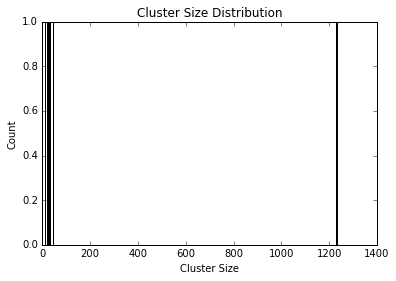

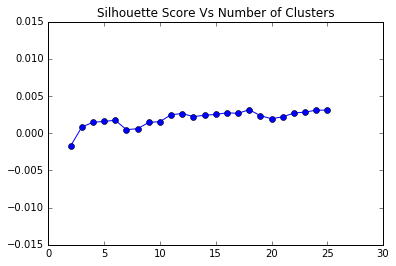

In [21]:
clustering_method='Agglomerative'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= n_clusters, **kwargs)
plot_silhouette_scores(clustering_method)

### 2. Hierarchical Clustering - $O(n^2 \log n)$

Clustering Algorithm: Hierarchical (complete)
Displaying Clusters by labels...
1 : ['fiberone', 'oreidapotatoes', 'spaghettios']
2 : ['drinktampico', 'mamamichelina', 'reliefinaction', 'thefoodfordogs']
3 : ['chefdontjudge', 'evianwater', 'hubertslemonade', 'nillawafers']
4 : ['barsfoods', 'fosterfarms', 'hinoderice', 'resers']
5 : ['flavorice_pops', 'otterpops']
6 : ['naturemade', 'naturesbounty']
7 : ['bestfoods', 'kikkomankitchen', 'kozyshack']
8 : ['eatsmartscales', 'gmtgiftbaskets', 'nostalgiaelctrx', 'sibu_beauty', 'teamkalorik', 'trukid']
9 : ['gopicnic', 'mrsrenfros']
10 : ['myarcticzero']
11 : ['popcorn_indiana', 'popcorners']
12 : ['buitoniusa', 'tortillaland']
13 : ['magellangps', 'zatarains']
14 : ['morningstrfarms', 'purell', 'redbaronpizza']
15 : ['mrbubble', 'resolveusa', 'roseartfun']
16 : ['greenworks', 'whirlpoolusa']
17 : ['jello', 'yocrunch']
18 : ['eckrichmeats']
19 : ['hillshirefarm', 'jimmydean']
20 : ['flatoutbread', 'starkistcharlie']
21 : ['freschetta', 'roman

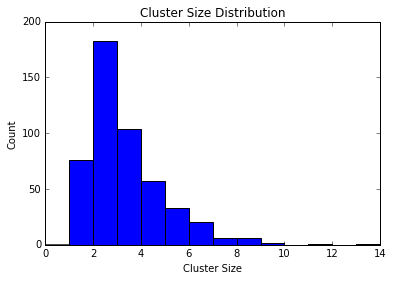

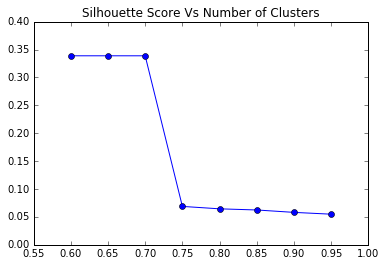

In [22]:
clustering_method='Hierarchical'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
kwargs['print_dendrogram'] = False
kwargs['threshold'] = 0.8
cluster_brands(clustering_method, num_clusters= n_clusters, **kwargs)
plot_silhouette_scores(clustering_method)

### 3. Spectral Clustering

Clustering Algorithm: Spectral (arpack,kmeans)
Displaying Clusters by labels...
0 : ['100percentpure', '18rabbits', '20thcenturyfox', '34degrees', '3mnews', '5hourenergy', '7daysinutopia', '7up', '8oclockcoffee', '8thcontinentsoy', 'abreva', 'acer', 'acne_free_skin', 'acneorg', 'act', 'acti_pr', 'activia', 'acura_insider', 'acureorganics', 'adidas', 'afterglow', 'aidstillreqd', 'airheadscandy', 'airwickmexico', 'alaffiaskincare', 'alchimieforever', 'alecjones33', 'alimapure', 'alissacohen', 'allegraotc', 'allegrocoffee', 'allure_magazine', 'alphahydrox', 'alternahaircare', 'alvaradostreet', 'always', 'amanabrand', 'ambipurindia', 'amerapparelsale', 'american_girl', 'ampenergy', 'ancientharvest', 'ancientminerals', 'andessn', 'angelicastiffy', 'anniesceo', 'annieshomegrown', 'anntaylor', 'anthropologie', 'antimonkeybutt', 'aphroditegy', 'april_rain', 'aprioridiamonds', 'aquafina', 'aquaphorus', 'arbonne', 'arcona_la', 'ardell_lashes', 'arizonadot', 'artisanafoods', 'artistrybeauty', 'as

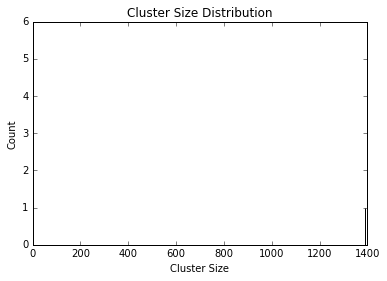

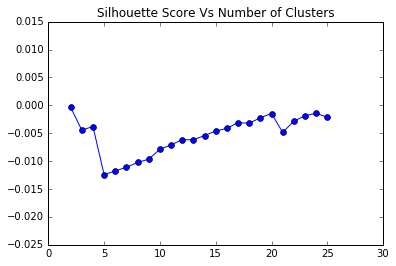

In [23]:
clustering_method='Spectral'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= n_clusters, **kwargs)
plot_silhouette_scores(clustering_method)

Clustering Algorithm: MySpectral without do_scale
Displaying Clusters by labels...
0 : ['100percentpure', '18rabbits', '20thcenturyfox', '34degrees', '3mnews', '5hourenergy', '7daysinutopia', '7up', '8oclockcoffee', '8thcontinentsoy', 'abreva', 'acer', 'acne_free_skin', 'acneorg', 'act', 'acti_pr', 'activia', 'acura_insider', 'acureorganics', 'adidas', 'afterglow', 'aidstillreqd', 'airheadscandy', 'airwickmexico', 'alaffiaskincare', 'alchimieforever', 'alecjones33', 'alimapure', 'alissacohen', 'allegraotc', 'allegrocoffee', 'allure_magazine', 'alphahydrox', 'alternahaircare', 'alvaradostreet', 'always', 'amanabrand', 'ambipurindia', 'amerapparelsale', 'american_girl', 'ampenergy', 'ancientharvest', 'ancientminerals', 'andessn', 'angelicastiffy', 'anniesceo', 'annieshomegrown', 'anntaylor', 'anthropologie', 'antimonkeybutt', 'aphroditegy', 'april_rain', 'aprioridiamonds', 'aquafina', 'aquaphorus', 'arbonne', 'arcona_la', 'ardell_lashes', 'arizonadot', 'artisanafoods', 'artistrybeauty', 

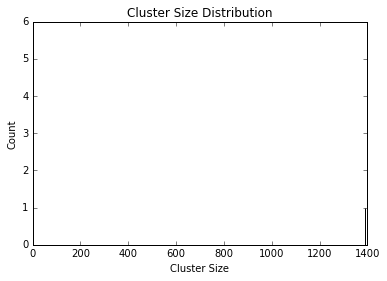

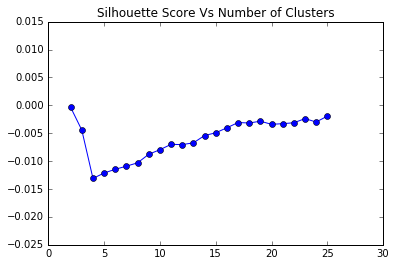

In [24]:
clustering_method='MySpectral'
kwargs = {}
kwargs['do_scale'] = False
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= n_clusters, **kwargs)
plot_silhouette_scores(clustering_method)

Clustering Algorithm: MySpectral with do_scale
Displaying Clusters by size...
217 ( 1 ): ['34degrees', '8thcontinentsoy', 'alchimieforever', 'ancientharvest', 'anniesceo', 'aprioridiamonds', 'aquaphorus', 'artistrybeauty', 'att', 'auracacia', 'aveneusa', 'axe', 'babobotanicals', 'bambinomio', 'bbuttonsbabies', 'bdbrows', 'belkin', 'better_oats', 'biokleeninc', 'bluediamond', 'bose', 'bulldognatural', 'bumgenius', 'butterfinger', 'cabotcheese', 'campbellschunky', 'carabnaturally', 'caudalieusa', 'chuaochocoholic', 'cleanwell', 'coastalscents', 'cobigelowny', 'colgate', 'customnails', 'davesgourmet', 'dawndish', 'decleoruk', 'dell', 'derma_e', 'dermorganic', 'devotedcreation', 'digiornopizza', 'dimpleskins', 'discover', 'dolefoods', 'downy', 'drbronner', 'drinktampico', 'dunkindonuts', 'duracell', 'earthlite', 'earthsbest', 'eatliquidgold', 'eco_me', 'ellentracyny', 'eltamd', 'fmchocolate', 'freemanbeauty', 'friskies', 'fritolay', 'fstg_chips', 'gain', 'gardein', 'gdiapers', 'gillette', 

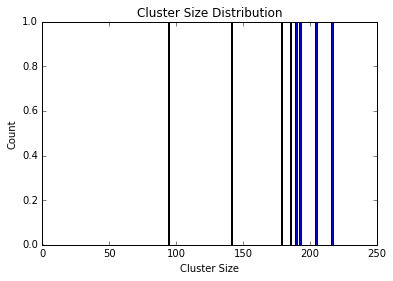

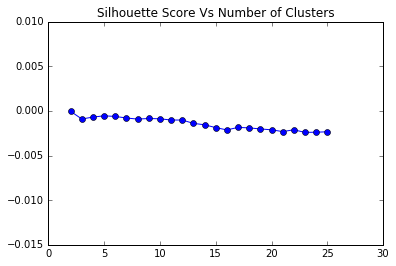

In [25]:
clustering_method='MySpectral1'
kwargs = {}
kwargs['do_scale'] = True
kwargs['print_clusters'] ='SIZE'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= n_clusters, **kwargs)
clustering_method='MySpectral1'
plot_silhouette_scores(clustering_method)

### To output clusters of different sizes

In [ ]:
clustering_method='MySpectral1'
kwargs = {}
kwargs['do_scale'] = True
kwargs['print_clusters'] ='SIZE'
kwargs['print_cluster_size'] = False

for i in range(1,51):
    print('Cluster Size:',i)
    cluster_brands(clustering_method, num_clusters= i, **kwargs)
